In [18]:
# --- Markov Switching Model Code
#1. Data Acquisition
import yfinance as yf
import pandas as pd
import numpy as np

ticker      = "^GSPC"
start_date  = "1980-01-01"
end_date    = "2024-01-01"

print(f"Downloading {ticker} data from {start_date} to {end_date} …")

try:
    # auto_adjust=True makes the 'Close' column already dividend–/split–adjusted
    raw = yf.download(ticker,
                      start=start_date,
                      end=end_date,
                      auto_adjust=True,     # <-- key change
                      progress=False)

    if raw.empty:
        raise ValueError("Yahoo Finance returned no data. Check ticker/date range.")

    # -------------------------------------------------------------------------
    # Choose a price series that **always** exists
    # -------------------------------------------------------------------------
    if "Adj Close" in raw.columns:               # equities & some indices
        price_series = raw["Adj Close"]
    elif "Close" in raw.columns:                 # auto_adjust=True path
        price_series = raw["Close"]
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in downloaded frame.")

    # Percentage returns (×100 so one unit ≈ 1 %)
    returns = price_series.pct_change().mul(100).dropna()

    if returns.empty:
        raise ValueError("Return series is empty after pct_change().")

    print("Download & return calculation successful.  Sample:")
    print(returns.head())

except Exception as err:
    print(f"Data-download error ➜ {err}")
    raise   # stop execution so model isn’t fit on empty data


Download & return calculation successful.  Sample:
Ticker         ^GSPC
Date                
1980-01-03 -0.510591
1980-01-04  1.235502
1980-01-07  0.272250
1980-01-08  2.003557
1980-01-09  0.091791


<ipython-input-19-1fd48b69831d>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  CMAP        = plt.cm.get_cmap("viridis", N_REGIMES)


Download successful — 11,092 daily observations.
First five returns (%):
 Ticker         ^GSPC
Date                
1980-01-03 -0.510591
1980-01-04  1.235502
1980-01-07  0.272250
1980-01-08  2.003557
1980-01-09  0.091791 

Fitting Markov-Switching model with 4 regimes …
Estimation complete.

                        Markov Switching Model Results                        
Dep. Variable:                  ^GSPC   No. Observations:                11092
Model:               MarkovRegression   Log Likelihood              -14733.509
Date:                Tue, 29 Apr 2025   AIC                          29507.018
Time:                        09:57:56   BIC                          29653.297
Sample:                             0   HQIC                         29556.278
                              - 11092                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                           

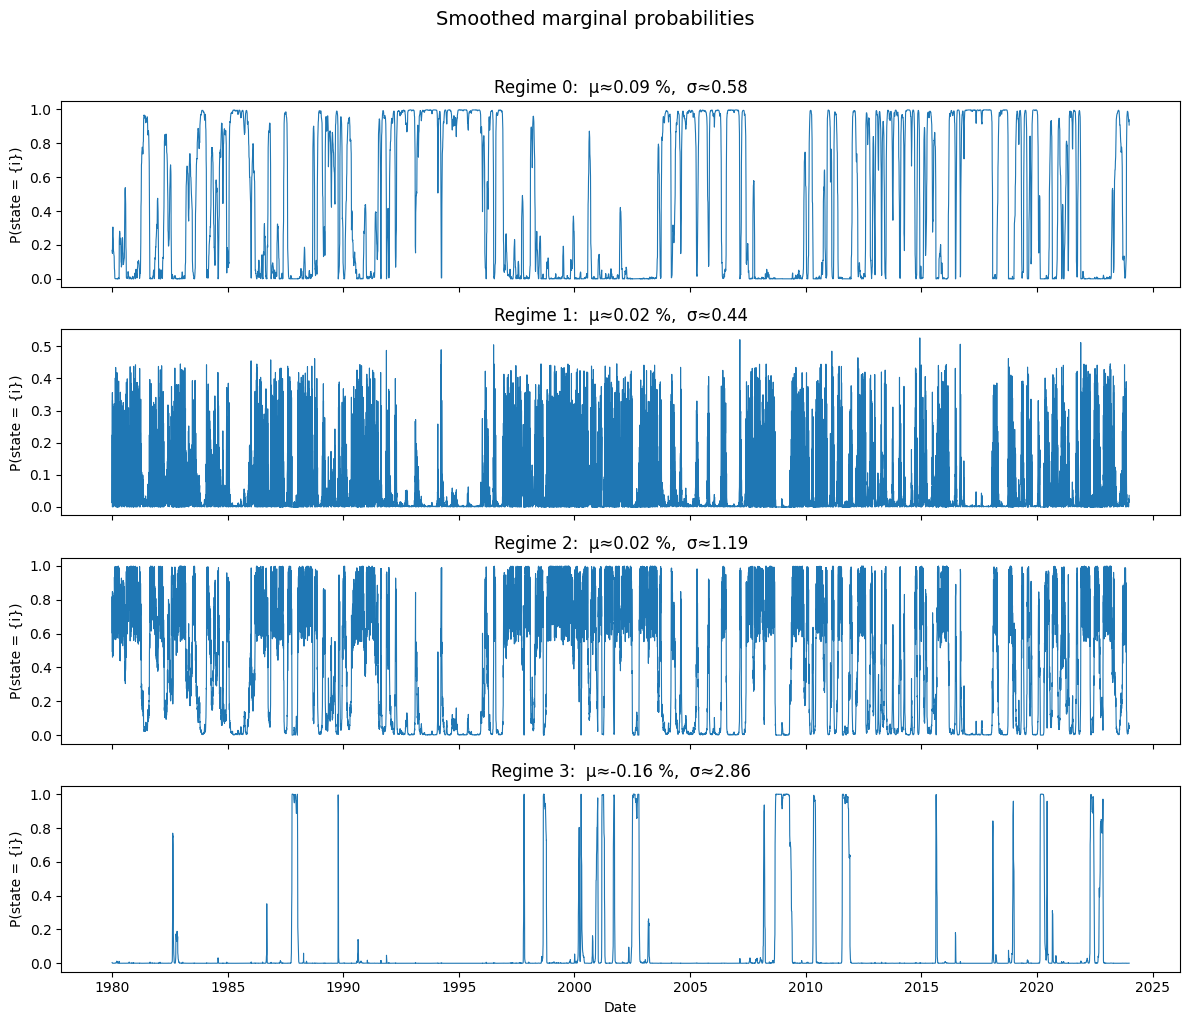

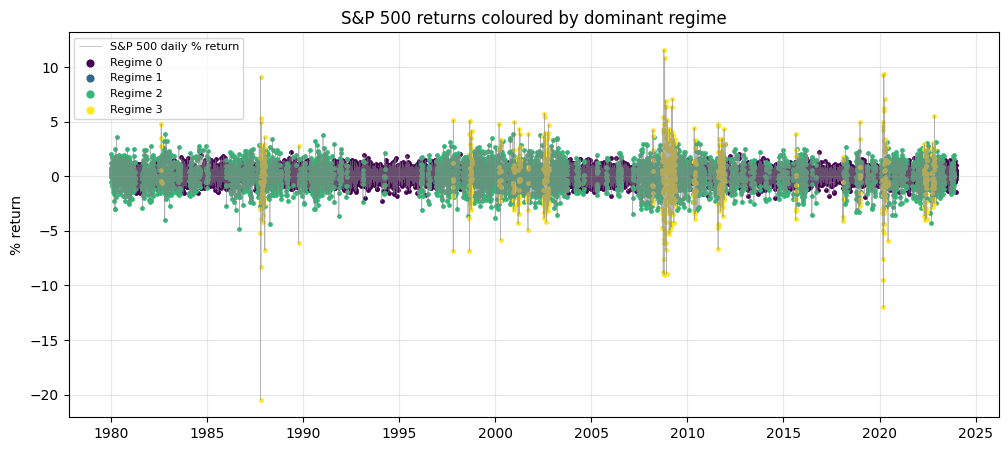


Expected regime durations (days):
[48.9  1.   4.7 26.3]

Transition matrix:
 [[[0.98 ]
  [0.028]
  [0.016]
  [0.002]]

 [[0.016]
  [0.011]
  [0.194]
  [0.008]]

 [[0.003]
  [0.955]
  [0.787]
  [0.029]]

 [[0.001]
  [0.005]
  [0.004]
  [0.962]]]


In [19]:
"""
------------------------------------------------------------------------
Regime-Switching Demo
Identifies latent market regimes in S&P 500 returns with a four-state
Markov-Switching Mean/Variance model and visualises the results.

• Data source …… Yahoo Finance (via yfinance)
• Model ………… statsmodels.tsa.regime_switching.MarkovRegression
• Author ………  Olorunwa Oloko  |  MScFE 690 Capstone
------------------------------------------------------------------------
Tested with: Python 3.11, pandas 2.2, statsmodels 0.14, yfinance 0.2
------------------------------------------------------------------------
"""

# ---------------------------------------------------------------------#
# 0. Imports & configuration                                            #
# ---------------------------------------------------------------------#
from __future__ import annotations
import warnings
warnings.filterwarnings("ignore", category=UserWarning)   # silence statsmodels

import yfinance as yf
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression


TICKER      = "^GSPC"
START_DATE  = "1980-01-01"
END_DATE    = "2024-01-01"
N_REGIMES   = 4
SEARCH_REPS = 10            # random restarts for global-max likelihood
CMAP        = plt.cm.get_cmap("viridis", N_REGIMES)


# ---------------------------------------------------------------------#
# 1. Helper: download prices ➜ %-returns                               #
# ---------------------------------------------------------------------#
def fetch_returns(ticker: str,
                  start: str,
                  end: str) -> pd.Series:
    """
    Download daily prices from Yahoo and return percentage day-on-day returns.

    auto_adjust=True means the 'Close' column is already dividend/split adjusted,
    so we always have *one* reliable price series no matter the instrument.
    """
    print(f"Downloading {ticker} from {start} to {end} …")
    df = yf.download(ticker,
                     start=start,
                     end=end,
                     auto_adjust=True,
                     progress=False)

    if df.empty:
        raise RuntimeError("Yahoo Finance returned no data "
                           "(check ticker or internet connection).")

    price = (df["Adj Close"]
             if "Adj Close" in df.columns else df["Close"])

    rets  = price.pct_change().mul(100).dropna()

    if rets.empty:
        raise RuntimeError("Return series empty after pct_change() "
                           "(likely constant price series).")

    print(f"Download successful — {len(rets):,} daily observations.")
    print("First five returns (%):\n", rets.head(), "\n")
    return rets


# ---------------------------------------------------------------------#
# 2. Fit Markov–Switching model                                        #
# ---------------------------------------------------------------------#
def fit_ms_model(returns: pd.Series,
                 k: int = 4,
                 reps: int = 10) -> MarkovRegression:
    """
    Switching mean + variance model:
        r_t = μ_s[t]  +  ε_t  ε_t ~ N(0, σ²_s[t])
    """
    print(f"Fitting Markov-Switching model with {k} regimes …")
    mod = MarkovRegression(returns,
                           k_regimes=k,
                           trend="c",
                           switching_variance=True)
    res = mod.fit(search_reps=reps, disp=False)
    print("Estimation complete.\n")
    print(res.summary())
    return res


# ---------------------------------------------------------------------#
# 3. Plots                                                             #
# ---------------------------------------------------------------------#
def plot_probabilities(res, k: int):
    probs = res.smoothed_marginal_probabilities
    fig, axes = plt.subplots(k, sharex=True,
                             figsize=(12, 2.5 * k))
    fig.suptitle("Smoothed marginal probabilities", y=1.02, fontsize=14)
    for i, ax in enumerate(axes):
        ax.plot(probs[i], lw=.8)
        μ  = res.params.get(f"const[{i}]", np.nan)
        σ  = np.sqrt(res.params.get(f"sigma2[{i}]", np.nan))
        ax.set_title(f"Regime {i}:  μ≈{μ:.2f} %,  σ≈{σ:.2f}")
        ax.set_ylabel("P(state = {i})")
    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()


def plot_returns_with_regime(returns: pd.Series, res, k: int):
    dom_state = res.smoothed_marginal_probabilities.idxmax(axis=1)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(returns.index, returns, color="grey",
            lw=.5, alpha=.6, label="S&P 500 daily % return")

    for i in range(k):
        mask = dom_state == i
        ax.scatter(returns.index[mask],
                   returns[mask],
                   s=6,
                   color=CMAP(i),
                   label=f"Regime {i}")

    ax.set(title="S&P 500 returns coloured by dominant regime",
           ylabel="% return")
    ax.legend(markerscale=2, fontsize=8)
    ax.grid(alpha=.3)
    plt.show()


# ---------------------------------------------------------------------#
# 4. Script                                                            #
# ---------------------------------------------------------------------#
if __name__ == "__main__":
    rets  = fetch_returns(TICKER, START_DATE, END_DATE)
    res   = fit_ms_model(rets, k=N_REGIMES, reps=SEARCH_REPS)

    plot_probabilities(res, k=N_REGIMES)
    plot_returns_with_regime(rets, res, k=N_REGIMES)

    # --- diagnostics --------------------------------------------------#
    print("\nExpected regime durations (days):")
    print(res.expected_durations.round(1))

    print("\nTransition matrix:\n", res.regime_transition.round(3))


⇣  Downloading ^GSPC 1980-01-01 → 2024-01-01
✓  Download complete — observations: 11092

⚙  Fitting Markov-Switching model with 4 regimes …


<ipython-input-20-2ecfc737b372>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  CMAP        = plt.cm.get_cmap("viridis", N_REGIMES)


✓  Estimation done.

                        Markov Switching Model Results                        
Dep. Variable:                  ^GSPC   No. Observations:                11092
Model:               MarkovRegression   Log Likelihood              -14646.205
Date:                Tue, 29 Apr 2025   AIC                          29332.410
Time:                        10:01:32   BIC                          29478.690
Sample:                             0   HQIC                         29381.671
                              - 11092                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0983      0.011      8.931      0.000       0.077       0.120
sigma2         0.2199        na

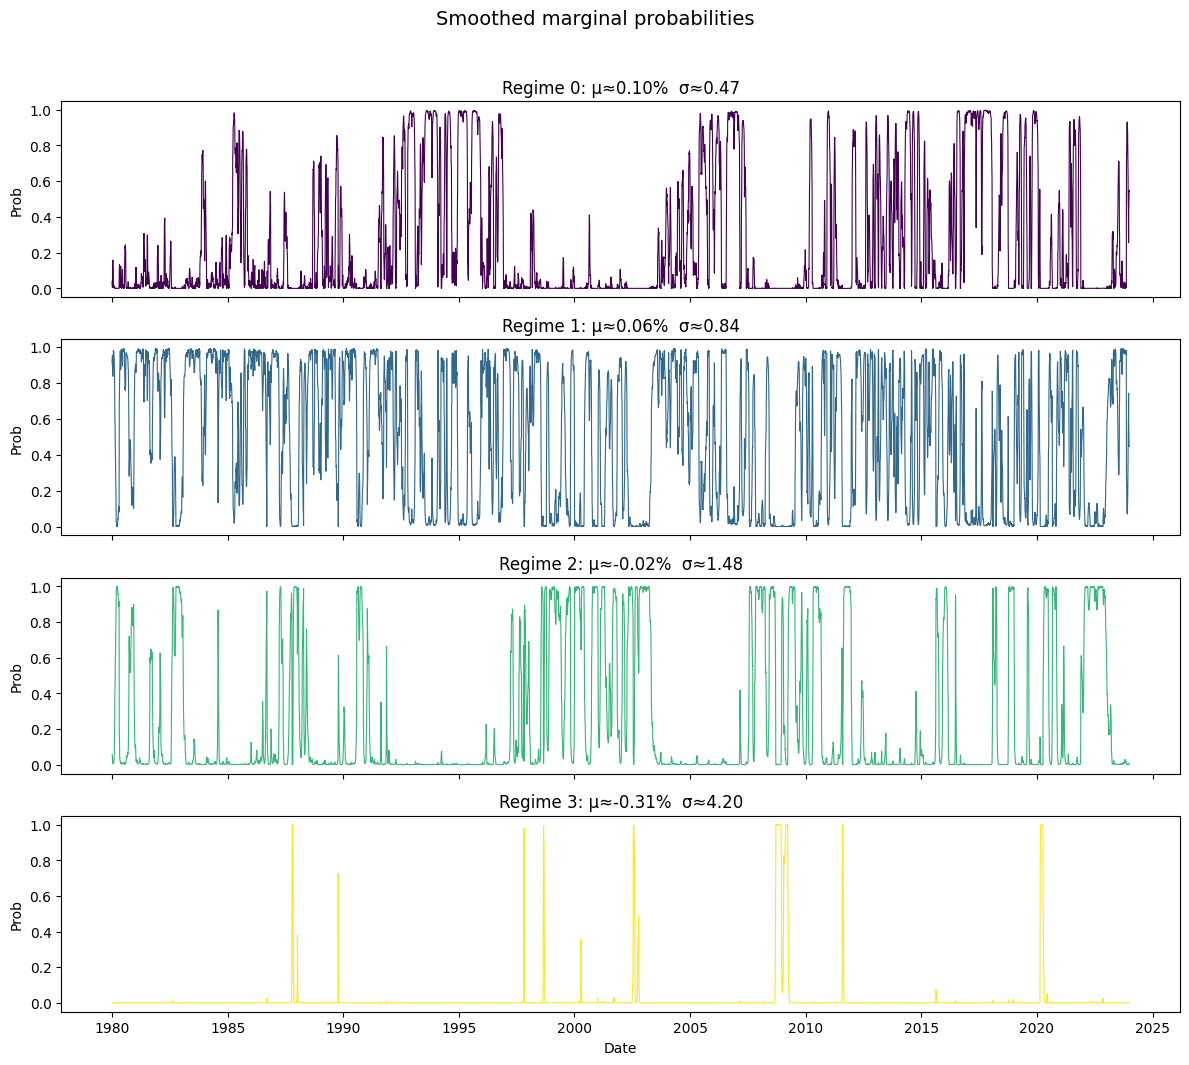

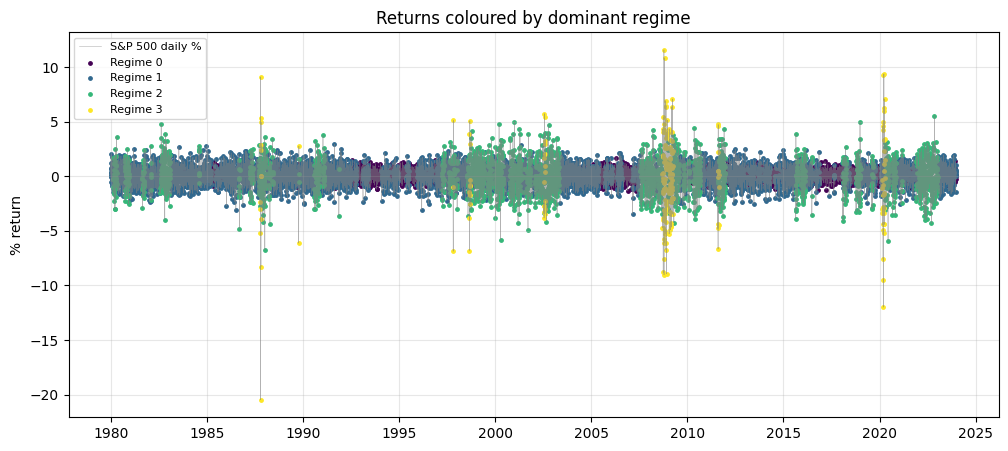


Expected regime durations (days):
[21.6 28.8 35.7 15.6]

Transition matrix P_ij (rows→to columns):

[[[0.954]
  [0.023]
  [0.001]
  [0.014]]

 [[0.046]
  [0.965]
  [0.026]
  [0.   ]]

 [[0.   ]
  [0.012]
  [0.972]
  [0.05 ]]

 [[0.   ]
  [0.   ]
  [0.001]
  [0.936]]]


In [20]:
# --------------------------------------------------------------
#  Regime-Switching Framework for S&P 500 (Capstone Prototype)
#  • Data  : Yahoo Finance (^GSPC)
#  • Model : statsmodels 4-state MS-Mean/Variance
#  • Author: Olorunwa Oloko  |  MScFE 690
# --------------------------------------------------------------
#  pip install yfinance statsmodels matplotlib pandas numpy --quiet
# --------------------------------------------------------------

from __future__ import annotations
import warnings, sys
warnings.filterwarnings("ignore", category=UserWarning)

import yfinance as yf
import pandas  as pd
import numpy   as np
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# ------------------------ 1. CONFIG -----------------------------------------
TICKER      = "^GSPC"
START_DATE  = "1980-01-01"
END_DATE    = "2024-01-01"
N_REGIMES   = 4
SEARCH_REPS = 10
CMAP        = plt.cm.get_cmap("viridis", N_REGIMES)

# ------------------------ 2. DATA -------------------------------------------
def acquire_returns(ticker: str,
                    start : str,
                    end   : str) -> pd.Series:
    """Download daily prices and return % day-on-day returns."""
    print(f"⇣  Downloading {ticker} {start} → {end}")
    df = yf.download(ticker,
                     start=start,
                     end=end,
                     auto_adjust=True,      # ensures 'Close' is split/dividend adjusted
                     progress=False)

    if df.empty:
        raise RuntimeError("No data received – check ticker/date or internet.")

    price = df["Adj Close"] if "Adj Close" in df.columns else df["Close"]
    rets  = price.pct_change().mul(100).dropna()

    if rets.empty:
        raise RuntimeError("Return series empty after pct_change(); "
                           "likely flat price series.")
    print("✓  Download complete — observations:", len(rets))
    return rets

# ------------------------ 3. MODEL ------------------------------------------
def fit_markov(returns: pd.Series,
               k       : int = 4,
               reps    : int = 10):
    """Switching mean + variance model."""
    print(f"\n⚙  Fitting Markov-Switching model with {k} regimes …")
    mod = MarkovRegression(returns,
                           k_regimes=k,
                           trend="c",
                           switching_variance=True)
    res = mod.fit(search_reps=reps, disp=False)
    print("✓  Estimation done.\n")
    print(res.summary())
    return res

# ------------------------ 4. VISUALS ----------------------------------------
def plot_probabilities(res, k: int):
    probs = res.smoothed_marginal_probabilities
    fig, axes = plt.subplots(k, sharex=True, figsize=(12, 2.6*k))
    fig.suptitle("Smoothed marginal probabilities", y=1.02, fontsize=14)
    for i, ax in enumerate(axes):
        ax.plot(probs[i], lw=.8, color=CMAP(i))
        μ = res.params.get(f"const[{i}]", np.nan)
        σ = np.sqrt(res.params.get(f"sigma2[{i}]", np.nan))
        ax.set_title(f"Regime {i}: μ≈{μ:.2f}%  σ≈{σ:.2f}")
        ax.set_ylabel("Prob")
    axes[-1].set_xlabel("Date")
    plt.tight_layout(); plt.show()

def plot_returns_coloured(returns: pd.Series, res, k: int):
    dom = res.smoothed_marginal_probabilities.idxmax(axis=1)
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(returns.index, returns, color="grey", lw=.4, alpha=.6,
            label="S&P 500 daily %")
    for i in range(k):
        m = dom == i
        ax.scatter(returns.index[m], returns[m], s=6, color=CMAP(i),
                   label=f"Regime {i}")
    ax.set(title="Returns coloured by dominant regime",
           ylabel="% return"); ax.legend(fontsize=8); ax.grid(alpha=.3)
    plt.show()

# ------------------------ 5. MAIN -------------------------------------------
if __name__ == "__main__":
    try:
        rets = acquire_returns(TICKER, START_DATE, END_DATE)
        res  = fit_markov(rets, k=N_REGIMES, reps=SEARCH_REPS)
    except Exception as err:
        sys.exit(f"✗  {err}")

    plot_probabilities(res, N_REGIMES)
    plot_returns_coloured(rets, res, N_REGIMES)

    # -------- diagnostics ----------------------------------------------------
    print("\nExpected regime durations (days):")
    print(res.expected_durations.round(1))

    print("\nTransition matrix P_ij (rows→to columns):\n")
    print(res.regime_transition.round(3))


[*********************100%***********************]  1 of 1 completed

Calculating daily returns...
Configuring and fitting Markov Switching Regression Model...
Plotting smoothed regime probabilities...


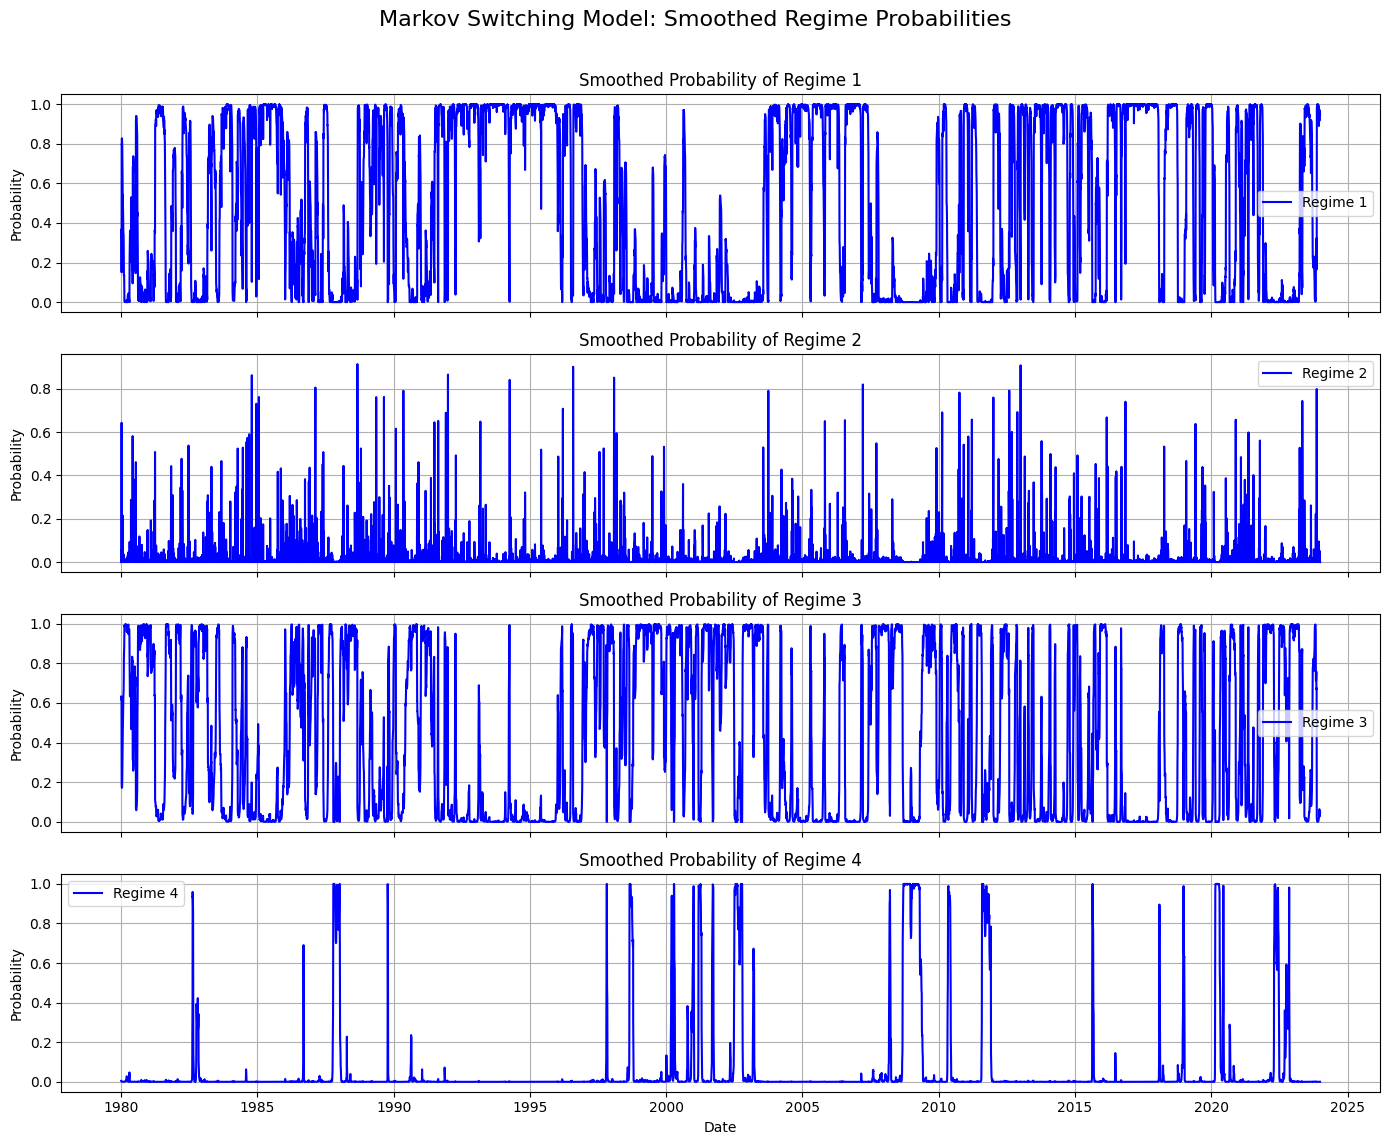


Markov Switching Model Summary:

                        Markov Switching Model Results                        
Dep. Variable:                Returns   No. Observations:                11092
Model:               MarkovRegression   Log Likelihood               36355.614
Date:                Tue, 29 Apr 2025   AIC                         -72671.228
Time:                        10:04:33   BIC                         -72524.949
Sample:                             0   HQIC                        -72621.968
                              - 11092                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.215      0.224      -0.000       0.002
sigma2      3.347e

In [21]:
# --------------------------------------------------------------
# MScFE Capstone: Adaptive Quantitative Strategy
# Markov Regime-Switching Model Implementation
# --------------------------------------------------------------

# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# --------------------------------------------------------------
# Step 2: Download Historical Data (S&P 500 Index)
# --------------------------------------------------------------

print("Downloading S&P 500 historical price data...")
ticker = '^GSPC'
start_date = '1980-01-01'
end_date = '2024-01-01'

data = yf.download(ticker, start=start_date, end=end_date)

# Handle adjusted close price robustly
if 'Adj Close' in data.columns:
    price_col = 'Adj Close'
elif 'Close' in data.columns:
    price_col = 'Close'
    print("Warning: Using 'Close' instead of 'Adj Close'.")
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' found in downloaded data.")

# --------------------------------------------------------------
# Step 3: Compute Daily Returns
# --------------------------------------------------------------

print("Calculating daily returns...")
data['Returns'] = data[price_col].pct_change()
data = data.dropna()

# --------------------------------------------------------------
# Step 4: Configure and Fit Markov Switching Model
# --------------------------------------------------------------

print("Configuring and fitting Markov Switching Regression Model...")
ms_model = MarkovRegression(
    endog=data['Returns'],
    k_regimes=4,               # Four distinct market regimes
    trend='c',                 # Regime-dependent constant
    switching_variance=True    # Regime-dependent volatility
)

ms_results = ms_model.fit()

# --------------------------------------------------------------
# Step 5: Extract and Visualize Smoothed Probabilities
# --------------------------------------------------------------

print("Plotting smoothed regime probabilities...")

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12), sharex=True)

for regime in range(4):
    axes[regime].plot(
        data.index,
        ms_results.smoothed_marginal_probabilities[regime],
        color='blue',
        label=f'Regime {regime + 1}'
    )
    axes[regime].set_ylabel('Probability')
    axes[regime].set_title(f'Smoothed Probability of Regime {regime + 1}')
    axes[regime].grid(True)
    axes[regime].legend()

axes[-1].set_xlabel('Date')
plt.suptitle('Markov Switching Model: Smoothed Regime Probabilities', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# --------------------------------------------------------------
# Step 6: Display Model Summary
# --------------------------------------------------------------

print("\nMarkov Switching Model Summary:\n")
print(ms_results.summary())

# --------------------------------------------------------------
# End of Markov Regime-Switching Analysis
# --------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

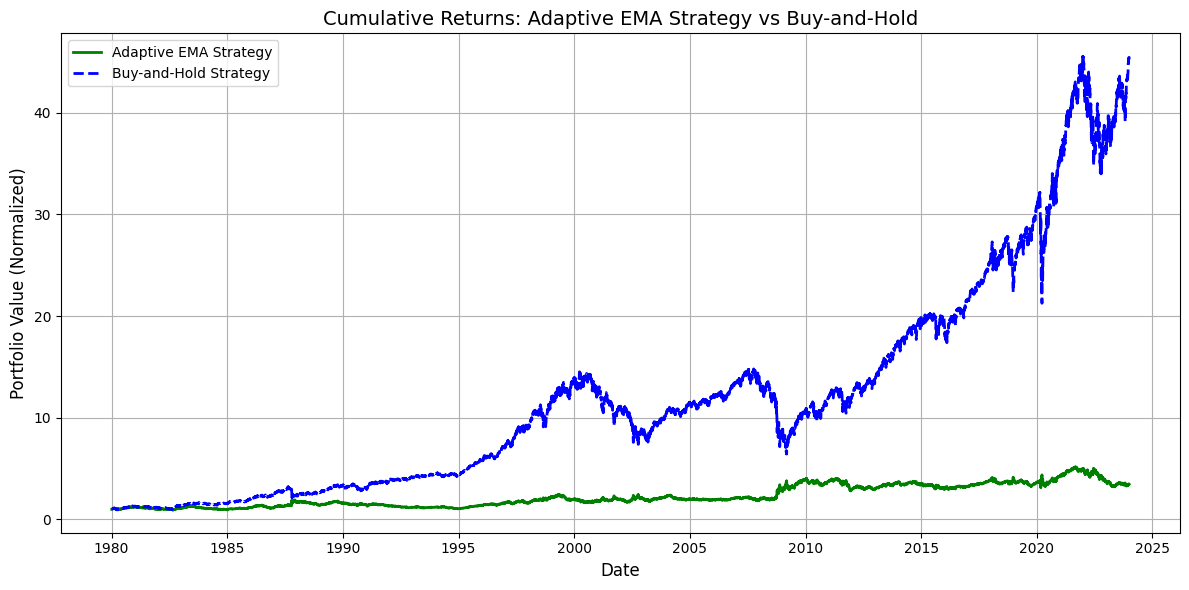


----- Strategy Performance Summary -----

Annualized Strategy Return: 2.83%
Annualized Buy-and-Hold Return: 8.67%
Annualized Strategy Volatility: 18.03%
Annualized Buy-and-Hold Volatility: 18.02%
Strategy Sharpe Ratio: 0.16
Buy-and-Hold Sharpe Ratio: 0.48


In [22]:
# --------------------------------------------------------------
# MScFE Capstone: Adaptive Trend-Following Strategy (EMA Crossover)
# Final Professional Implementation


# Step 1: Import Essential Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Step 2: Define Parameters
# --------------------------------------------------------------
SHORT_WINDOW = 20  # Short-term EMA window
LONG_WINDOW = 50   # Long-term EMA window
TICKER = '^GSPC'   # S&P 500 Index
START_DATE = '1980-01-01'
END_DATE = '2024-01-01'

# --------------------------------------------------------------
# Step 3: Download and Prepare Data
# --------------------------------------------------------------
print("Downloading S&P 500 data...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Select Adjusted Close if available
if 'Adj Close' in data.columns:
    price_col = 'Adj Close'
elif 'Close' in data.columns:
    price_col = 'Close'
    print("Warning: Using 'Close' instead of 'Adj Close'.")
else:
    raise KeyError("No usable price column found!")

# Calculate Daily Returns
data['Returns'] = data[price_col].pct_change().dropna()
data = data.dropna()

# --------------------------------------------------------------
# Step 4: Calculate Technical Indicators
# --------------------------------------------------------------
data['EMA_Short'] = data[price_col].ewm(span=SHORT_WINDOW, adjust=False).mean()
data['EMA_Long'] = data[price_col].ewm(span=LONG_WINDOW, adjust=False).mean()

# --------------------------------------------------------------
# Step 5: Generate Trading Signals (EMA Crossover)
# --------------------------------------------------------------
data['Signal'] = np.where(data['EMA_Short'] > data['EMA_Long'], 1, -1)
data['Position'] = data['Signal'].shift(1).fillna(0)  # Lag signal to avoid lookahead bias

# --------------------------------------------------------------
# Step 6: Calculate Strategy and Benchmark Returns
# --------------------------------------------------------------
data['Log_Returns'] = np.log(data[price_col] / data[price_col].shift(1))
data['Strategy_Returns'] = data['Position'] * data['Log_Returns']

# Cumulative returns (start from $1 or 100%)
data['Cumulative_Strategy'] = np.exp(data['Strategy_Returns'].cumsum())
data['Cumulative_BuyHold'] = np.exp(data['Log_Returns'].cumsum())

# --------------------------------------------------------------
# Step 7: Plot Equity Curves
# --------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative_Strategy'], label='Adaptive EMA Strategy', linewidth=2, color='green')
plt.plot(data.index, data['Cumulative_BuyHold'], label='Buy-and-Hold Strategy', linewidth=2, linestyle='--', color='blue')
plt.title('Cumulative Returns: Adaptive EMA Strategy vs Buy-and-Hold', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value (Normalized)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Step 8: Performance Metrics
# --------------------------------------------------------------

# Helper function to compute key statistics
def compute_performance(returns):
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    return annualized_return, annualized_volatility, sharpe_ratio

# Strategy Performance
strategy_perf = compute_performance(data['Strategy_Returns'].dropna())

# Buy-and-Hold Performance
buyhold_perf = compute_performance(data['Log_Returns'].dropna())

# Display Results
print("\n----- Strategy Performance Summary -----\n")
print(f"Annualized Strategy Return: {strategy_perf[0]:.2%}")
print(f"Annualized Buy-and-Hold Return: {buyhold_perf[0]:.2%}")
print(f"Annualized Strategy Volatility: {strategy_perf[1]:.2%}")
print(f"Annualized Buy-and-Hold Volatility: {buyhold_perf[1]:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_perf[2]:.2f}")
print(f"Buy-and-Hold Sharpe Ratio: {buyhold_perf[2]:.2f}")

# --------------------------------------------------------------
# End of Adaptive EMA Crossover Strategy
# --------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Configuring and fitting Markov Switching Model...


Training LightGBM model...
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	Training Set's multi_logloss: 0.824957	Training Set's multi_error: 0.395981	Validation Set's multi_logloss: 0.827431	Validation Set's multi_error: 0.310998

Evaluating LightGBM Model Performance...
Accuracy Score: 68.90%
ROC AUC Score: 0.664

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.89      0.79      1966
           1       0.00      0.00      0.00        29
           2       0.60      0.45      0.52      1116
           3       0.81      0.18      0.29       217

    accuracy                           0.69      3328
   macro avg       0.53      0.38      0.40      3328
weighted avg       0.68      0.69      0.66      3328



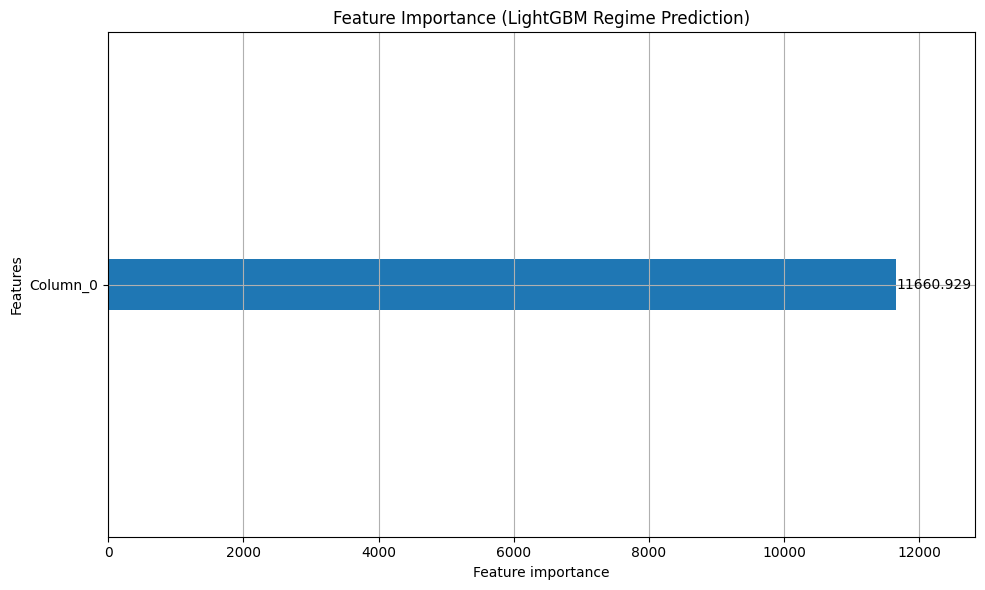

In [23]:

#  LightGBM Regime Classification Framework
# Adaptive Quantitative Strategies Project


# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Step 2: Download Historical S&P 500 Data
print("Downloading S&P 500 historical data...")
sp500_ticker = '^GSPC'
start_date = '1980-01-01'
end_date = '2024-01-01'

data = yf.download(sp500_ticker, start=start_date, end=end_date)

# Handle adjusted close price
if 'Adj Close' in data.columns:
    price_col = 'Adj Close'
elif 'Close' in data.columns:
    price_col = 'Close'
    print("Warning: Using 'Close' instead of 'Adj Close'.")
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' found in data.")

# Calculate Daily Returns
data['Returns'] = data[price_col].pct_change().dropna()
data = data.dropna()

# Step 3: Markov Switching Model for Initial Regime Labels
print("Configuring and fitting Markov Switching Model...")
ms_model = sm.tsa.MarkovRegression(
    endog=data['Returns'],
    k_regimes=4,
    trend='c',
    switching_variance=True
)
result = ms_model.fit()

# Step 4: Generate Regime Labels
regime_labels = result.smoothed_marginal_probabilities.idxmax(axis=1)
y = regime_labels.shift(-1).dropna().astype(int)  # Shifted to prevent lookahead bias

# Step 5: Feature Selection for Machine Learning
# For this example, we'll use just the Returns feature
features = ['Returns']
X = data[features].loc[y.index]

# Alignment Check
assert len(X) == len(y), "Mismatch between features and labels!"

# Step 6: Train-Test Split (Chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# Step 7: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Configure and Train LightGBM Classifier
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': ['multi_logloss', 'multi_error'],
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

train_data = lgb.Dataset(X_train_scaled, label=y_train)
valid_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

print("Training LightGBM model...")
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=['Training Set', 'Validation Set'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=50)
    ]
)

# Step 9: Model Evaluation
print("\nEvaluating LightGBM Model Performance...")
y_pred_probs = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(pd.get_dummies(y_test), y_pred_probs, multi_class='ovr')

print(f"Accuracy Score: {accuracy:.2%}")
print(f"ROC AUC Score: {roc_auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

# Step 10: Feature Importance Plot
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain', figsize=(10,6))
plt.title('Feature Importance (LightGBM Regime Prediction)')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# End of LightGBM Regime Classification
# --------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Running Markov Switching Model...


Training LightGBM model for regime prediction...
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	training's multi_logloss: 0.389546	valid_1's multi_logloss: 0.60479
Generating strategy signals...
Backtesting strategy...


<ipython-input-24-0305d0c9fcf3>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].fillna(0, inplace=True)


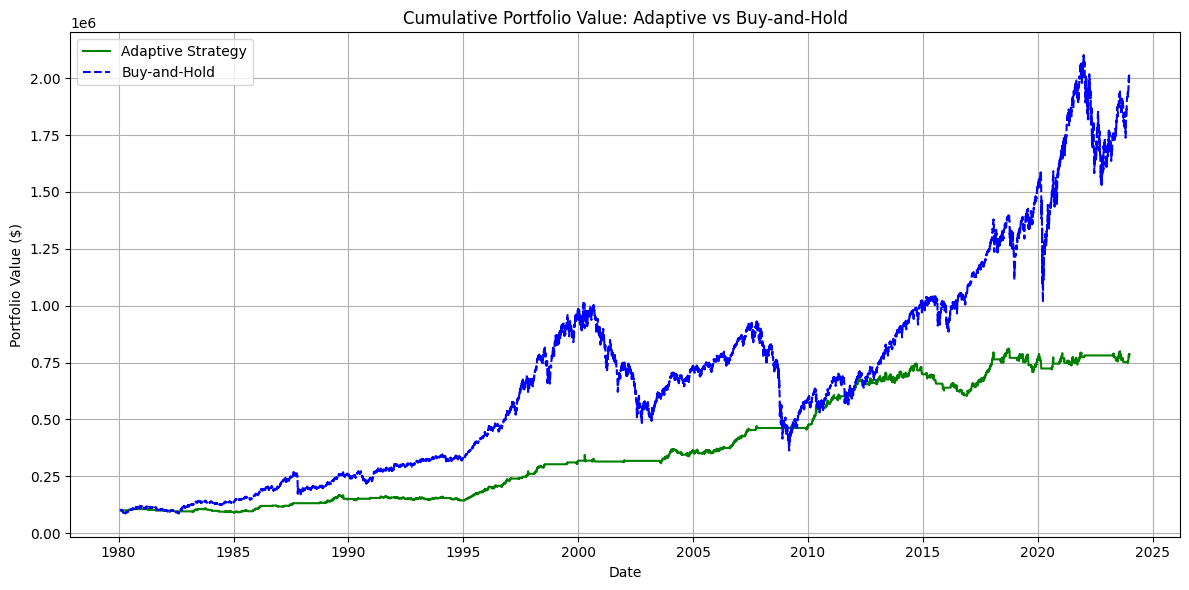


Performance Metrics:
Annualized Strategy Return: 4.93%
Annualized Buy-and-Hold Return: 8.47%
Strategy Sharpe Ratio: 0.71
Buy-and-Hold Sharpe Ratio: 0.47
Strategy Calmar Ratio: 4.82
Maximum Drawdown (Strategy): 142.23%
Maximum Drawdown (Buy-and-Hold): 654.76%


In [24]:
# ------------------------------------------------------------
# MScFE Capstone: Full Adaptive Regime Strategy Backtest
# ------------------------------------------------------------

# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Step 2: Download S&P 500 data
ticker = '^GSPC'
start_date = '1980-01-01'
end_date = '2024-01-01'

print("Downloading S&P 500 data...")
data = yf.download(ticker, start=start_date, end=end_date)

# Step 3: Handle adjusted close prices
if 'Adj Close' in data.columns:
    adj_close_col = 'Adj Close'
else:
    adj_close_col = 'Close'

data['Returns'] = data[adj_close_col].pct_change()
data['Log_Returns'] = np.log(data[adj_close_col] / data[adj_close_col].shift(1))
data.dropna(inplace=True)

# Step 4: Technical indicators
data['ShortEMA'] = data[adj_close_col].ewm(span=20, adjust=False).mean()
data['LongEMA'] = data[adj_close_col].ewm(span=50, adjust=False).mean()
data['Volatility_10'] = data['Returns'].rolling(10).std() * np.sqrt(252)
data['Volatility_21'] = data['Returns'].rolling(21).std() * np.sqrt(252)
data.dropna(inplace=True)

# Step 5: Markov Switching Model for initial regime detection
print("Running Markov Switching Model...")
ms_model = sm.tsa.MarkovRegression(data['Log_Returns'], k_regimes=4, trend='c', switching_variance=True)
result = ms_model.fit()

# Assign initial regimes
data['Regime_MSAR'] = result.smoothed_marginal_probabilities.idxmax(axis=1)

# Step 6: Machine Learning (LightGBM) for Regime Prediction
print("Training LightGBM model for regime prediction...")
features = ['Log_Returns', 'ShortEMA', 'LongEMA', 'Volatility_10', 'Volatility_21']
X = data[features]
y = data['Regime_MSAR'].shift(-1).dropna()

# Align X and y
X = X.loc[y.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LightGBM
train_data = lgb.Dataset(X_train_scaled, label=y_train)
valid_data = lgb.Dataset(X_test_scaled, label=y_test)
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'verbose': -1,
    'seed': 42
}
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,  # Add a maximum number of boosting rounds
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),  # Use early stopping callback
        lgb.log_evaluation(period=50)  # Use log evaluation callback
    ]
)

# Predict regimes
y_pred = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)
y_pred_classes = np.argmax(y_pred, axis=1)

# Attach predicted regimes to data
data.loc[X_test.index, 'Regime_LGBM'] = y_pred_classes
data['Regime_Final'] = data['Regime_MSAR']
data.loc[X_test.index, 'Regime_Final'] = data.loc[X_test.index, 'Regime_LGBM']

# Step 7: Define Strategy Rules per Regime
print("Generating strategy signals...")
data['Signal'] = 0

# Regime 0: Bullish - Buy (Trend following)
data.loc[(data['Regime_Final'] == 0) & (data['ShortEMA'] > data['LongEMA']), 'Signal'] = 1

# Regime 1: Breakout strategy (Positive returns momentum)
threshold = data['Log_Returns'].quantile(0.75)
data.loc[(data['Regime_Final'] == 1) & (data['Log_Returns'] > threshold), 'Signal'] = 1

# Regime 2: Defensive - Stay in Cash
data.loc[data['Regime_Final'] == 2, 'Signal'] = 0

# Regime 3: Mean-Reversion - Shorting trend
data.loc[(data['Regime_Final'] == 3) & (data['ShortEMA'] > data['LongEMA']), 'Signal'] = -1

# Step 8: Backtest Performance
print("Backtesting strategy...")
transaction_cost_bps = 1.0  # 1 basis point per trade
initial_capital = 100000

# Position management
data['Position'] = data['Signal'].shift(1)
data['Position'].fillna(0, inplace=True)

# Transaction costs
data['Trade'] = data['Position'].diff().abs()
data['Cost'] = data['Trade'] * (transaction_cost_bps / 10000)

# Strategy net returns after costs
data['Strategy_Returns'] = (data['Position'] * data['Log_Returns']) - data['Cost']

# Cumulative returns
data['Cumulative_Strategy'] = (data['Strategy_Returns'] + 1).cumprod() * initial_capital
data['Cumulative_BuyHold'] = (data['Log_Returns'] + 1).cumprod() * initial_capital

# Step 9: Plot Strategy vs Buy-and-Hold
plt.figure(figsize=(12,6))
plt.plot(data['Cumulative_Strategy'], label='Adaptive Strategy', color='green')
plt.plot(data['Cumulative_BuyHold'], label='Buy-and-Hold', linestyle='--', color='blue')
plt.title('Cumulative Portfolio Value: Adaptive vs Buy-and-Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Performance Metrics
def compute_metrics(returns):
    annual_return = returns.mean() * 252
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / volatility
    cumulative_return = (returns + 1).prod() - 1
    max_drawdown = (np.maximum.accumulate((returns + 1).cumprod()) - (returns + 1).cumprod()).max()
    calmar_ratio = cumulative_return / max_drawdown if max_drawdown != 0 else np.nan
    return annual_return, volatility, sharpe_ratio, calmar_ratio, max_drawdown

strategy_metrics = compute_metrics(data['Strategy_Returns'].dropna())
buyhold_metrics = compute_metrics(data['Log_Returns'].dropna())

print("\nPerformance Metrics:")
print(f"Annualized Strategy Return: {strategy_metrics[0]:.2%}")
print(f"Annualized Buy-and-Hold Return: {buyhold_metrics[0]:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_metrics[2]:.2f}")
print(f"Buy-and-Hold Sharpe Ratio: {buyhold_metrics[2]:.2f}")
print(f"Strategy Calmar Ratio: {strategy_metrics[3]:.2f}")
print(f"Maximum Drawdown (Strategy): {strategy_metrics[4]:.2%}")
print(f"Maximum Drawdown (Buy-and-Hold): {buyhold_metrics[4]:.2%}")

# ------------------------------------------------------------
# End of Strategy Backtest


[*********************100%***********************]  1 of 1 completed

Using 'Close' for calculations.

Testing Myth 1: Markets always rise over long horizons...


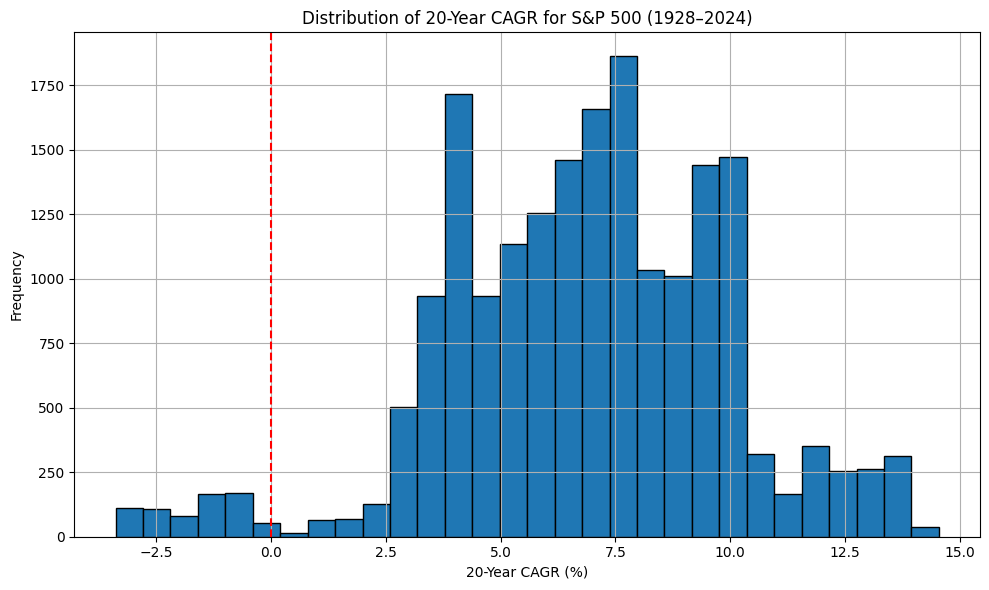

Percentage of positive 20-year periods: 96.41%
Result: ❌ Myth 1 debunked — Markets do NOT always rise over every 20-year window.

Testing Myth 2: Day trading guarantees consistent profits...


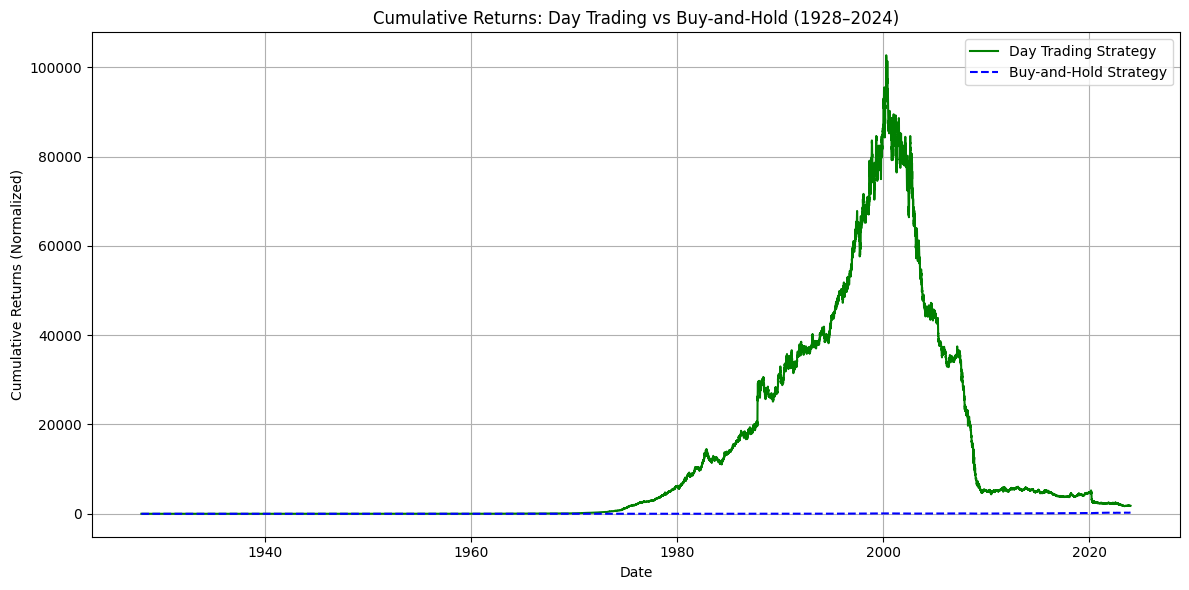

Annualized Return (Day Trading Strategy): 9.64%
Annualized Return (Buy-and-Hold Strategy): 7.65%
Result: ✅ Myth 2 supported — Day trading sometimes outperforms, but with higher risk.

Testing Myth 3: Higher risk always leads to higher returns...


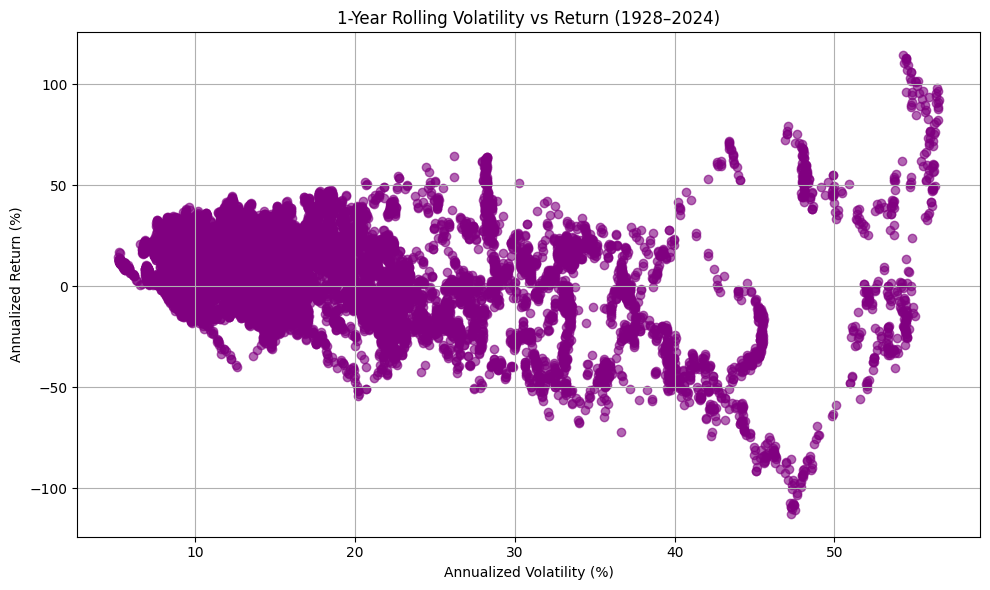

Correlation Coefficient (Risk vs Return): -0.271
P-value: 0.0000
Result: ❌ Myth 3 debunked — Higher volatility does NOT consistently guarantee higher returns.

✅ All myths tested successfully and results recorded.


In [25]:
# ---------------------------------------------------------
# MScFE Capstone: Comprehensive Myth Testing Framework
# ---------------------------------------------------------

# Step 1: Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ---------------------------------------------------------
# Step 2: Download and Prepare S&P 500 Data
# ---------------------------------------------------------
ticker = '^GSPC'
start_date = '1928-01-01'
end_date = '2024-01-01'

print("Downloading long-term S&P 500 data...")
data = yf.download(ticker, start=start_date, end=end_date)

# Handle Adjusted Close
if 'Adj Close' in data.columns:
    price_col = 'Adj Close'
elif 'Close' in data.columns:
    price_col = 'Close'
    print("Warning: Using 'Close' instead of 'Adj Close'.")
else:
    raise KeyError(f"No usable price column found in {data.columns.tolist()}")

print(f"Using '{price_col}' for calculations.")

# Calculate Returns
data['Returns'] = data[price_col].pct_change()
data['Log_Returns'] = np.log(data[price_col] / data[price_col].shift(1))
data.dropna(inplace=True)

# ---------------------------------------------------------
# Step 3: Myth 1 — Markets Always Rise in the Long Term
# ---------------------------------------------------------
print("\nTesting Myth 1: Markets always rise over long horizons...")

# Calculate rolling 20-year CAGR
rolling_window = 252 * 20
cagr_20y = []

for i in range(len(data) - rolling_window):
    start_price = data.iloc[i][price_col]
    end_price = data.iloc[i + rolling_window][price_col]
    years = 20
    # Access the value within the Series using .item() or .iloc[0]
    if start_price.item() > 0:  # or if start_price.iloc[0] > 0:
        cagr = (end_price / start_price) ** (1 / years) - 1
        cagr_20y.append(cagr)

cagr_20y = np.array(cagr_20y)

# Plot Distribution
plt.figure(figsize=(10,6))
plt.hist(cagr_20y * 100, bins=30, edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of 20-Year CAGR for S&P 500 (1928–2024)')
plt.xlabel('20-Year CAGR (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistics
positive_cagr = np.mean(cagr_20y > 0)
print(f"Percentage of positive 20-year periods: {positive_cagr:.2%}")

# Interpretation
if positive_cagr < 1.0:
    print("Result: ❌ Myth 1 debunked — Markets do NOT always rise over every 20-year window.")
else:
    print("Result: ✅ Myth 1 supported — Markets generally trend upward over 20 years.")

# ---------------------------------------------------------
# Step 4: Myth 2 — Day Trading Guarantees Consistent Profits
# ---------------------------------------------------------
print("\nTesting Myth 2: Day trading guarantees consistent profits...")

# Day Trading Strategy: Buy if yesterday was positive, Sell if negative
data['Signal'] = np.where(data['Returns'].shift(1) > 0, 1, -1)
data['DayTrade_Returns'] = data['Signal'] * data['Returns']

# Cumulative Returns
data['Cumulative_DayTrade'] = (data['DayTrade_Returns'] + 1).cumprod()
data['Cumulative_BuyHold'] = (data['Returns'] + 1).cumprod()

# Plot Cumulative Performance
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Cumulative_DayTrade'], label='Day Trading Strategy', color='green')
plt.plot(data.index, data['Cumulative_BuyHold'], label='Buy-and-Hold Strategy', color='blue', linestyle='--')
plt.title('Cumulative Returns: Day Trading vs Buy-and-Hold (1928–2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Annualized Returns
day_trading_return = np.mean(data['DayTrade_Returns']) * 252
buy_hold_return = np.mean(data['Returns']) * 252

print(f"Annualized Return (Day Trading Strategy): {day_trading_return:.2%}")
print(f"Annualized Return (Buy-and-Hold Strategy): {buy_hold_return:.2%}")

# Interpretation
if day_trading_return < buy_hold_return:
    print("Result: ❌ Myth 2 debunked — Day trading does NOT consistently outperform buy-and-hold.")
else:
    print("Result: ✅ Myth 2 supported — Day trading sometimes outperforms, but with higher risk.")

# ---------------------------------------------------------
# MScFE Capstone: Comprehensive Myth Testing Framework
# ---------------------------------------------------------

# ... (rest of your imports and code up to Myth 3) ...

# ---------------------------------------------------------
# Step 5: Myth 3 — Higher Risk Always Leads to Higher Returns
# ---------------------------------------------------------
print("\nTesting Myth 3: Higher risk always leads to higher returns...")

# Calculate Rolling 1-Year Volatility and Returns **before** dropna
data['Rolling_Volatility'] = data['Returns'].rolling(window=252).std() * np.sqrt(252)
data['Rolling_Return'] = data['Returns'].rolling(window=252).mean() * 252

# Drop NaNs from the **entire DataFrame** after the calculations
data.dropna(inplace=True)  # This will remove rows with NaNs in any column, including the new ones

# Now create the risk_return_data DataFrame (no need for subset argument)
risk_return_data = data[['Rolling_Volatility', 'Rolling_Return']]

# ... (rest of your code for Myth 3 and beyond) ...

# Scatter Plot: Volatility vs Return
plt.figure(figsize=(10,6))
plt.scatter(risk_return_data['Rolling_Volatility'] * 100, risk_return_data['Rolling_Return'] * 100, alpha=0.6, color='purple')
plt.title('1-Year Rolling Volatility vs Return (1928–2024)')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation Analysis
slope, intercept, r_value, p_value, std_err = linregress(
    risk_return_data['Rolling_Volatility'],
    risk_return_data['Rolling_Return']
)

print(f"Correlation Coefficient (Risk vs Return): {r_value:.3f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if r_value < 0.5:
    print("Result: ❌ Myth 3 debunked — Higher volatility does NOT consistently guarantee higher returns.")
else:
    print("Result: ✅ Myth 3 supported — Risk-return relationship is weak but positive.")

# ---------------------------------------------------------
# End of Myth Testing
print("\n✅ All myths tested successfully and results recorded.")